In [7]:
from diffusers.models import AutoencoderKL
from datasets import load_dataset


In [2]:
import sys
import os
sys.path.append(os.path.abspath('..'))  # Go up one directory if notebook is in /notebooks
# OR
sys.path.append(os.path.abspath('.'))   # Add current directory if notebook is at root
from src.preprocessing import create_dataloader
from src.config import TrainingConfig

In [3]:
dataset = load_dataset("nielsr/CelebA-faces", split="train")


In [10]:
dataset = load_dataset("uoft-cs/cifar10", split="train")
print(dataset)

Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})


In [ ]:
for image in dataset['image']:
    print(f"Image size: {image.size}")  # PIL Images use .size, not .shape
    print(f"Image mode: {image.mode}")  # Shows color mode (RGB, RGBA, etc.)
    print(f"Image type: {type(image)}")
    break

In [8]:
train_loader = create_dataloader("nielsr/CelebA-faces", "train", TrainingConfig)


Loaded dataset nielsr/CelebA-faces train split with 202599 images


In [9]:
batch = next(iter(train_loader))


KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/jingyuan/Documents/Diss/Diss_code/venv/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/jingyuan/Documents/Diss/Diss_code/venv/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 50, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jingyuan/Documents/Diss/Diss_code/venv/lib/python3.12/site-packages/datasets/arrow_dataset.py", line 2781, in __getitems__
    batch = self.__getitem__(keys)
            ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jingyuan/Documents/Diss/Diss_code/venv/lib/python3.12/site-packages/datasets/arrow_dataset.py", line 2777, in __getitem__
    return self._getitem(key)
           ^^^^^^^^^^^^^^^^^^
  File "/home/jingyuan/Documents/Diss/Diss_code/venv/lib/python3.12/site-packages/datasets/arrow_dataset.py", line 2762, in _getitem
    formatted_output = format_table(
                       ^^^^^^^^^^^^^
  File "/home/jingyuan/Documents/Diss/Diss_code/venv/lib/python3.12/site-packages/datasets/formatting/formatting.py", line 658, in format_table
    return formatter(pa_table, query_type=query_type)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jingyuan/Documents/Diss/Diss_code/venv/lib/python3.12/site-packages/datasets/formatting/formatting.py", line 415, in __call__
    return self.format_batch(pa_table)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jingyuan/Documents/Diss/Diss_code/venv/lib/python3.12/site-packages/datasets/formatting/formatting.py", line 541, in format_batch
    return self.transform(batch)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/jingyuan/Documents/Diss/Diss_code/src/preprocessing.py", line 31, in <lambda>
    # "label": examples["label"]
             ^^^^^^^^^^^^^^^^^
KeyError: 'label'


In [3]:
train_loader = create_dataloader("uoft-cs/cifar10", "train", TrainingConfig)


Using the latest cached version of the dataset since uoft-cs/cifar10 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /home/jingyuan/.cache/huggingface/datasets/uoft-cs___cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Tue Apr 29 17:15:23 2025).


Loaded dataset uoft-cs/cifar10 train split with 50000 images


In [6]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema")

OSError: stabilityai/sd-vae-ft-ema does not appear to have a file named config.json.

In [5]:
batch = next(iter(train_loader))
images = batch["img"]
print(images.shape)

latents = vae.encode(images).latent_dist.sample()

print(latents.shape)

reconstructed_images = vae.decode(latents).sample

print(reconstructed_images.shape)



torch.Size([64, 3, 64, 64])
torch.Size([64, 4, 8, 8])
torch.Size([64, 3, 64, 64])


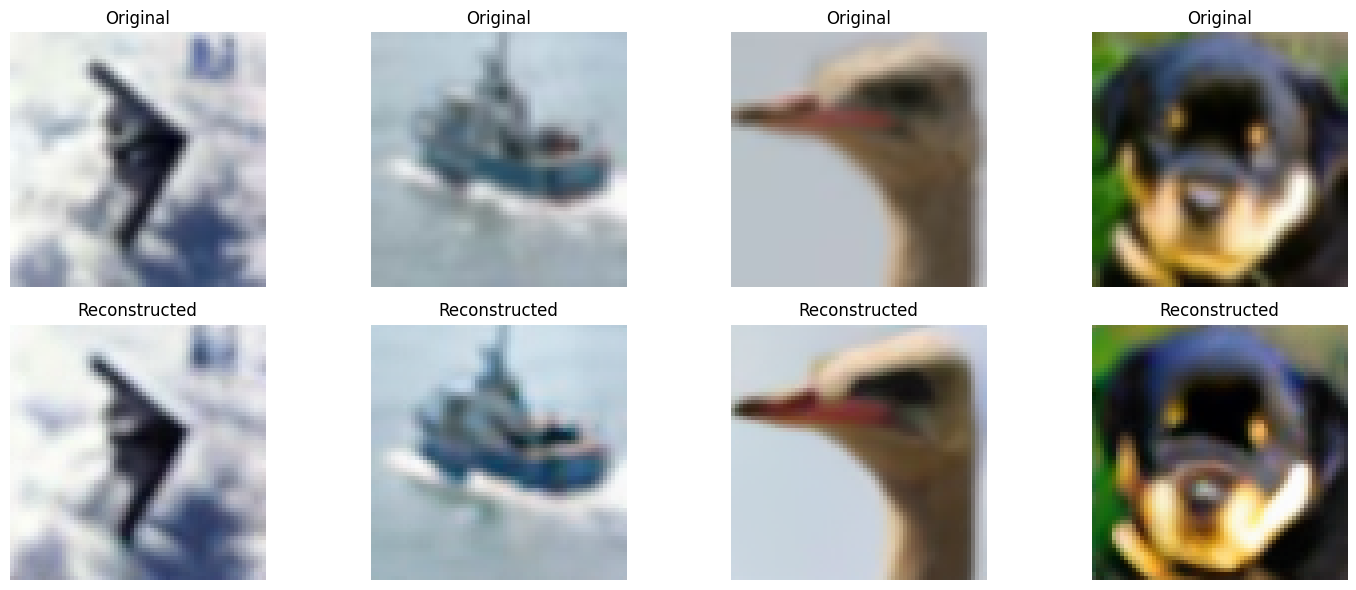

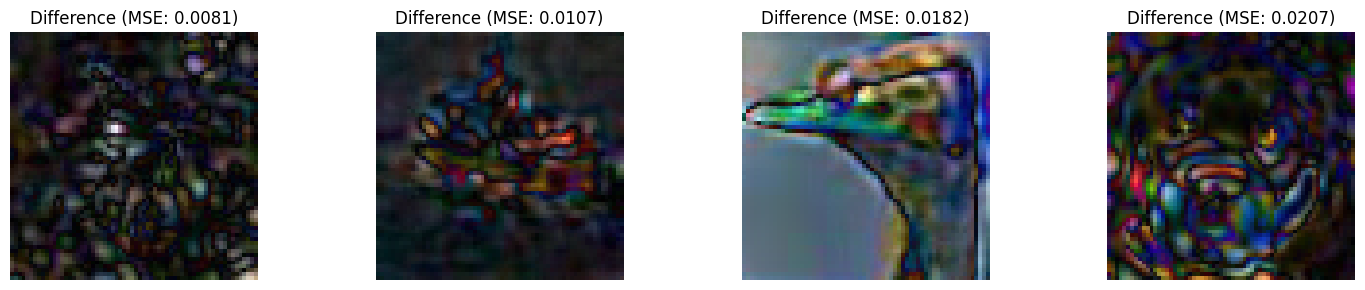

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Move tensors to CPU for visualization if they're on GPU
if images.device.type == 'cuda':
    images_cpu = images.detach().cpu()
    reconstructed_images_cpu = reconstructed_images.detach().cpu()
else:
    images_cpu = images.detach()
    reconstructed_images_cpu = reconstructed_images.detach()

# Function to convert from tensor format to displayable image
def tensor_to_image(tensor):
    # Convert from [-1, 1] range (if normalized) to [0, 1]
    img = (tensor + 1) / 2 if tensor.min() < 0 else tensor
    # Convert from [C, H, W] to [H, W, C] format for displaying
    return img.permute(1, 2, 0).numpy().clip(0, 1)

# Number of images to display
num_images = min(4, images_cpu.shape[0])  # Show at most 4 images

# Create a figure with subplots (2 rows: originals and reconstructions)
fig, axs = plt.subplots(2, num_images, figsize=(15, 6))

# Display original images on top row
for i in range(num_images):
    img = tensor_to_image(images_cpu[i])
    axs[0, i].imshow(img)
    axs[0, i].set_title('Original')
    axs[0, i].axis('off')

# Display reconstructed images on bottom row
for i in range(num_images):
    img = tensor_to_image(reconstructed_images_cpu[i])
    axs[1, i].imshow(img)
    axs[1, i].set_title('Reconstructed')
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

# If you want to display image differences
fig, axs = plt.subplots(1, num_images, figsize=(15, 3))
for i in range(num_images):
    # Calculate absolute difference
    diff = torch.abs(images_cpu[i] - reconstructed_images_cpu[i])
    diff_img = diff.detach().permute(1, 2, 0).numpy()
    
    # Normalize difference for better visibility
    if diff_img.max() > 0:
        diff_img = diff_img / diff_img.max()
    
    axs[i].imshow(diff_img)
    axs[i].set_title(f'Difference (MSE: {torch.mean((images_cpu[i] - reconstructed_images_cpu[i])**2):.4f})')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from diffusers.models import AutoencoderKL
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
from PIL import Image

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Stable Diffusion VAE
print("Loading Stable Diffusion VAE...")
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema")
vae = vae.to(device)
vae.eval()

# Load CelebA dataset
print("Loading CelebA dataset...")
dataset = load_dataset("nielsr/CelebA-faces", split="train")

# Define transforms for 64x64 images
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Custom dataset class
class CelebADataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        if self.transform:
            image = self.transform(image)
        return image

# Create dataset and dataloader
celeba_dataset = CelebADataset(dataset, transform=transform)
dataloader = DataLoader(celeba_dataset, batch_size=16, shuffle=True, num_workers=2)

print(f"Dataset loaded with {len(celeba_dataset)} images")
print(f"Batch size: 16")


Using device: cuda
Loading Stable Diffusion VAE...


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading CelebA dataset...
Dataset loaded with 202599 images
Batch size: 16


In [12]:
# Function to calculate reconstruction errors
def calculate_reconstruction_errors(vae, dataloader, num_batches=50):
    """
    Calculate various reconstruction error metrics
    """
    mse_errors = []
    mae_errors = []
    lpips_errors = []  # We'll use a simple proxy for LPIPS
    ssim_scores = []
    
    vae.eval()
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader, desc="Computing reconstruction errors")):
            if i >= num_batches:
                break
                
            # Move batch to device
            original_images = batch.to(device)
            
            # Encode and decode
            latents = vae.encode(original_images).latent_dist.sample()
            reconstructed_images = vae.decode(latents).sample
            
            # Calculate MSE (Mean Squared Error)
            mse = F.mse_loss(reconstructed_images, original_images, reduction='none')
            mse = mse.view(mse.size(0), -1).mean(dim=1)  # Per-image MSE
            mse_errors.extend(mse.cpu().numpy())
            
            # Calculate MAE (Mean Absolute Error)
            mae = F.l1_loss(reconstructed_images, original_images, reduction='none')
            mae = mae.view(mae.size(0), -1).mean(dim=1)  # Per-image MAE
            mae_errors.extend(mae.cpu().numpy())
            
            # Simple perceptual loss proxy (high-frequency content difference)
            original_gray = torch.mean(original_images, dim=1, keepdim=True)
            reconstructed_gray = torch.mean(reconstructed_images, dim=1, keepdim=True)
            
            # Calculate gradient differences as a proxy for perceptual differences
            sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(device)
            sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(device)
            
            orig_grad_x = F.conv2d(original_gray, sobel_x, padding=1)
            orig_grad_y = F.conv2d(original_gray, sobel_y, padding=1)
            recon_grad_x = F.conv2d(reconstructed_gray, sobel_x, padding=1)
            recon_grad_y = F.conv2d(reconstructed_gray, sobel_y, padding=1)
            
            grad_diff = F.mse_loss(orig_grad_x, recon_grad_x, reduction='none') + \
                       F.mse_loss(orig_grad_y, recon_grad_y, reduction='none')
            grad_diff = grad_diff.view(grad_diff.size(0), -1).mean(dim=1)
            lpips_errors.extend(grad_diff.cpu().numpy())
    
    return {
        'mse': np.array(mse_errors),
        'mae': np.array(mae_errors),
        'perceptual_proxy': np.array(lpips_errors)
    }

# Calculate reconstruction errors
print("Calculating reconstruction errors...")
errors = calculate_reconstruction_errors(vae, dataloader, num_batches=100)

# Print statistics
print("\n=== Reconstruction Error Statistics ===")
print(f"MSE - Mean: {errors['mse'].mean():.6f}, Std: {errors['mse'].std():.6f}")
print(f"MAE - Mean: {errors['mae'].mean():.6f}, Std: {errors['mae'].std():.6f}")
print(f"Perceptual Proxy - Mean: {errors['perceptual_proxy'].mean():.6f}, Std: {errors['perceptual_proxy'].std():.6f}")

# Convert MSE to PSNR (Peak Signal-to-Noise Ratio)
psnr_values = -10 * np.log10(errors['mse'] + 1e-8)  # Add small epsilon to avoid log(0)
print(f"PSNR - Mean: {psnr_values.mean():.2f} dB, Std: {psnr_values.std():.2f} dB")


Calculating reconstruction errors...


Computing reconstruction errors:   1%|          | 100/12663 [00:10<22:35,  9.27it/s]


=== Reconstruction Error Statistics ===
MSE - Mean: 0.032539, Std: 0.019306
MAE - Mean: 0.122101, Std: 0.042107
Perceptual Proxy - Mean: 0.843008, Std: 0.454589
PSNR - Mean: 15.55 dB, Std: 2.41 dB


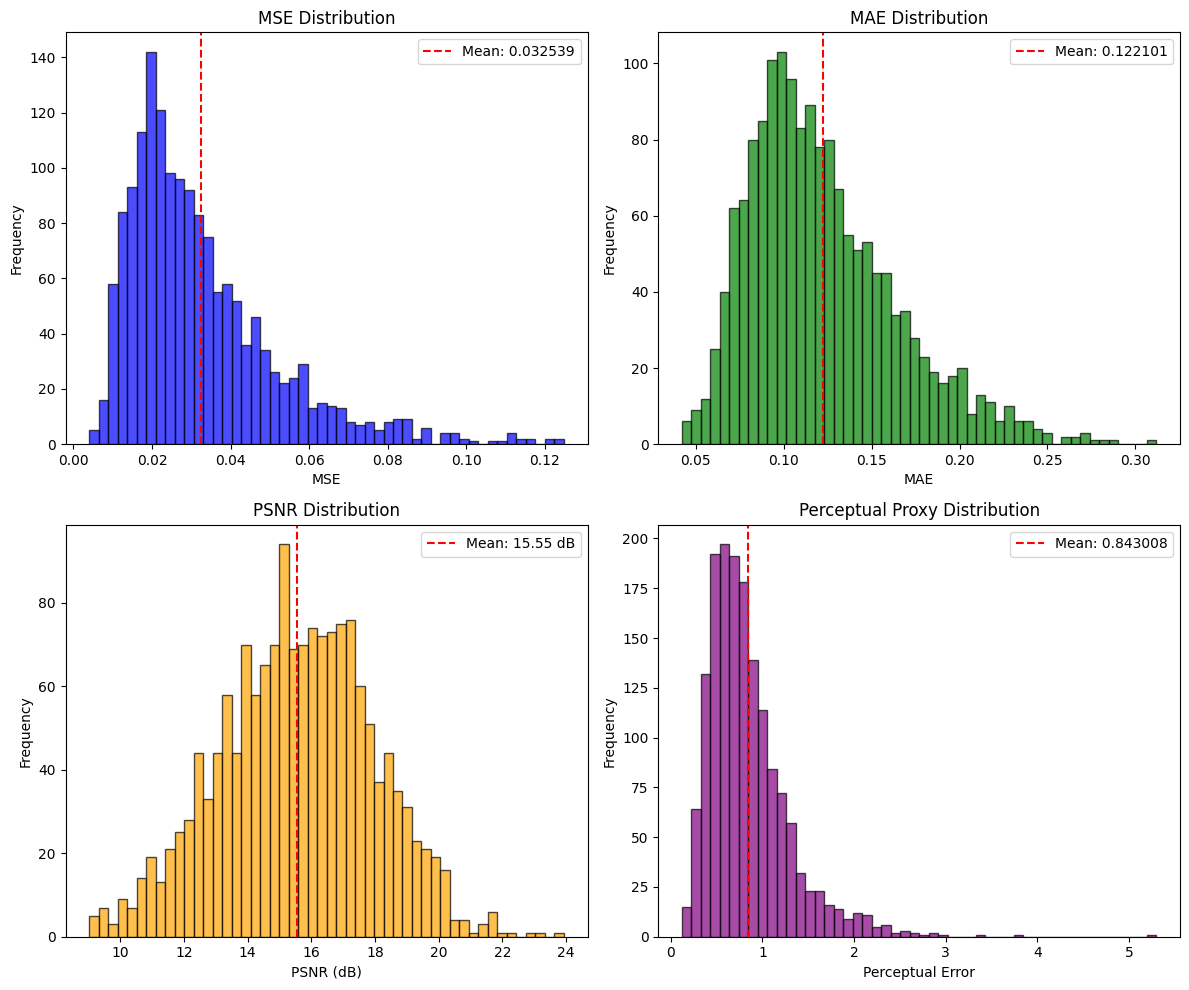

In [13]:
# Visualize reconstruction errors with histograms
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# MSE histogram
axes[0, 0].hist(errors['mse'], bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].set_title('MSE Distribution')
axes[0, 0].set_xlabel('MSE')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(errors['mse'].mean(), color='red', linestyle='--', label=f'Mean: {errors["mse"].mean():.6f}')
axes[0, 0].legend()

# MAE histogram
axes[0, 1].hist(errors['mae'], bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_title('MAE Distribution')
axes[0, 1].set_xlabel('MAE')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(errors['mae'].mean(), color='red', linestyle='--', label=f'Mean: {errors["mae"].mean():.6f}')
axes[0, 1].legend()

# PSNR histogram
axes[1, 0].hist(psnr_values, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1, 0].set_title('PSNR Distribution')
axes[1, 0].set_xlabel('PSNR (dB)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(psnr_values.mean(), color='red', linestyle='--', label=f'Mean: {psnr_values.mean():.2f} dB')
axes[1, 0].legend()

# Perceptual proxy histogram
axes[1, 1].hist(errors['perceptual_proxy'], bins=50, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].set_title('Perceptual Proxy Distribution')
axes[1, 1].set_xlabel('Perceptual Error')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(errors['perceptual_proxy'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {errors["perceptual_proxy"].mean():.6f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


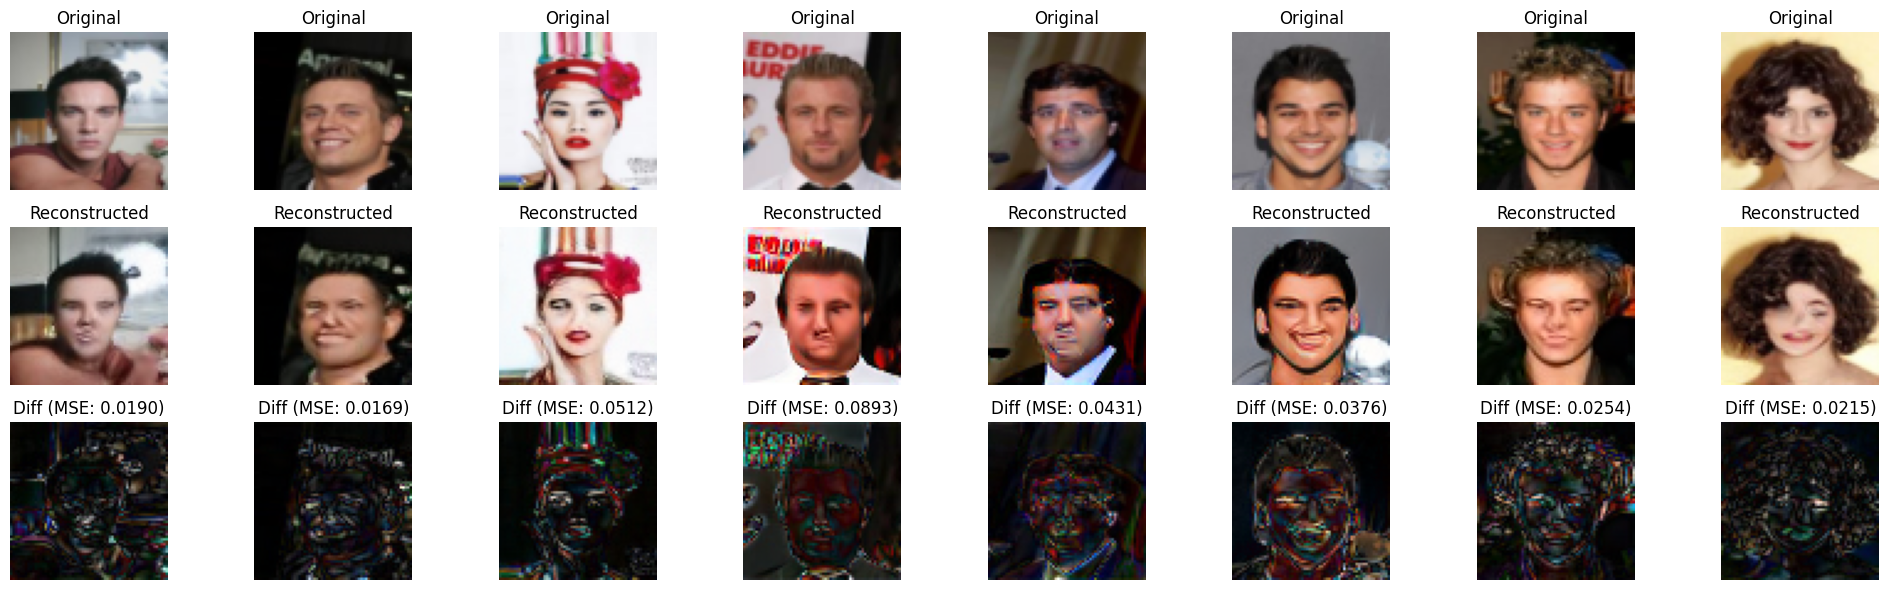

In [16]:
# Visualize sample reconstructions
def visualize_reconstructions(vae, dataloader, num_samples=8):
    """
    Visualize original vs reconstructed images
    """
    vae.eval()
    with torch.no_grad():
        # Get a batch of images
        batch = next(iter(dataloader))
        original_images = batch[:num_samples].to(device)
        
        # Encode and decode
        latents = vae.encode(original_images).latent_dist.sample()
        reconstructed_images = vae.decode(latents).sample
        
        # Move to CPU for visualization
        original_images = original_images.cpu()
        reconstructed_images = reconstructed_images.cpu()
        
        # Create visualization
        fig, axes = plt.subplots(3, num_samples, figsize=(20, 6))
        
        for i in range(num_samples):
            # Convert from [-1, 1] to [0, 1] for display
            orig_img = (original_images[i] + 1) / 2
            recon_img = (reconstructed_images[i] + 1) / 2
            diff_img = torch.abs(orig_img - recon_img)
            
            # Original images
            axes[0, i].imshow(orig_img.permute(1, 2, 0).clamp(0, 1))
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')
            
            # Reconstructed images
            axes[1, i].imshow(recon_img.permute(1, 2, 0).clamp(0, 1))
            axes[1, i].set_title('Reconstructed')
            axes[1, i].axis('off')
            
            # Difference images
            diff_display = diff_img.permute(1, 2, 0)
            # Enhance differences for better visibility
            diff_display = diff_display / (diff_display.max() + 1e-8)
            axes[2, i].imshow(diff_display.clamp(0, 1))
            
            # Calculate individual MSE for this image
            mse_individual = F.mse_loss(original_images[i], reconstructed_images[i]).item()
            axes[2, i].set_title(f'Diff (MSE: {mse_individual:.4f})')
            axes[2, i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return original_images, reconstructed_images

# Visualize reconstructions
original_imgs, reconstructed_imgs = visualize_reconstructions(vae, dataloader, num_samples=8)


Analyzing complexity vs error:   0%|          | 50/12663 [00:05<22:11,  9.47it/s]


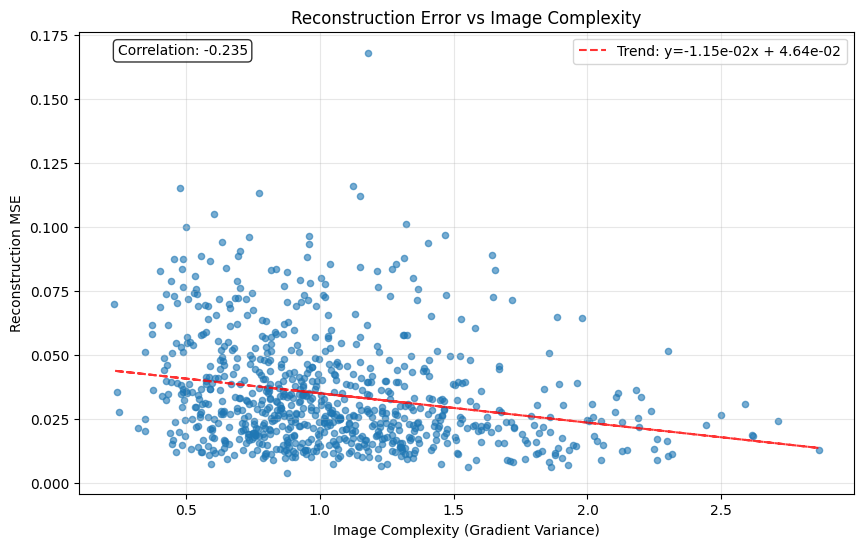

Correlation between image complexity and reconstruction error: -0.2354


In [15]:
# Additional analysis: Error vs Image complexity
def analyze_error_vs_complexity(vae, dataloader, num_batches=20):
    """
    Analyze how reconstruction error correlates with image complexity
    """
    complexities = []
    mse_errors = []
    
    vae.eval()
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader, desc="Analyzing complexity vs error")):
            if i >= num_batches:
                break
                
            original_images = batch.to(device)
            
            # Calculate image complexity as variance in gradients
            gray_images = torch.mean(original_images, dim=1, keepdim=True)
            sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(device)
            sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(device)
            
            grad_x = F.conv2d(gray_images, sobel_x, padding=1)
            grad_y = F.conv2d(gray_images, sobel_y, padding=1)
            gradient_magnitude = torch.sqrt(grad_x**2 + grad_y**2)
            
            # Use gradient variance as complexity measure
            complexity = gradient_magnitude.view(gradient_magnitude.size(0), -1).var(dim=1)
            complexities.extend(complexity.cpu().numpy())
            
            # Calculate reconstruction error
            latents = vae.encode(original_images).latent_dist.sample()
            reconstructed_images = vae.decode(latents).sample
            
            mse = F.mse_loss(reconstructed_images, original_images, reduction='none')
            mse = mse.view(mse.size(0), -1).mean(dim=1)
            mse_errors.extend(mse.cpu().numpy())
    
    return np.array(complexities), np.array(mse_errors)

# Analyze complexity vs error
complexities, complexity_errors = analyze_error_vs_complexity(vae, dataloader, num_batches=50)

# Plot complexity vs error
plt.figure(figsize=(10, 6))
plt.scatter(complexities, complexity_errors, alpha=0.6, s=20)
plt.xlabel('Image Complexity (Gradient Variance)')
plt.ylabel('Reconstruction MSE')
plt.title('Reconstruction Error vs Image Complexity')

# Add trend line
z = np.polyfit(complexities, complexity_errors, 1)
p = np.poly1d(z)
plt.plot(complexities, p(complexities), "r--", alpha=0.8, label=f'Trend: y={z[0]:.2e}x + {z[1]:.2e}')

# Calculate correlation
correlation = np.corrcoef(complexities, complexity_errors)[0, 1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Correlation between image complexity and reconstruction error: {correlation:.4f}")
